# Bitcoin Stock Price Prediction

Bitcoin, the world's first decentralized cryptocurrency, was created in 2009 by the mysterious Satoshi Nakamoto. It operates on a technology called blockchain, a distributed ledger that records transactions across many computers. Bitcoin's supply is limited to 21 million coins, and new coins are created through a process called mining. This process involves powerful computers solving complex mathematical problems to verify and add transactions to the blockchain. Bitcoin's price has been highly volatile, experiencing significant fluctuations over the years. It has been praised for its potential to revolutionize finance and criticized for its energy consumption and association with illicit activities.

**Table of Content**

* Import Data and Library
* Data Preprocessing
    * Missing value
    * convert date to dateformat
    * split dataset into train and test
    * Normalise
    * Convert into Matrix
    * Reshape to build LSTM Model
* Build LSTM Model
    * sequence
    * LSTM Layer
    * Dense Layer
    * Compile
    * Fit
* Evaluate the model
    * RMSE,MSE,MAE
    * R2SCORE


# Import Library and Data

In [1]:
# First we will import the necessary Library

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
maindf=pd.read_csv('BTC-USD.csv')

In [3]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2713 non-null   object 
 1   Open       2713 non-null   float64
 2   High       2713 non-null   float64
 3   Low        2713 non-null   float64
 4   Close      2713 non-null   float64
 5   Adj Close  2713 non-null   float64
 6   Volume     2713 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 148.5+ KB


* 7 columns and 2713 rows
* There are 5 float,1 Object,1 int Datatype for better understanding of the dataset

# Data Preprocessing

## Finding Missing Values

In [5]:
print(maindf.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


* No Missing value in Dataset

## Convert Date to DateFormat

In [6]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

In [7]:
maindf['Date']

,Date
0,2014-09-17
1,2014-09-18
2,2014-09-19
3,2014-09-20
4,2014-09-21
...,...
2708,2022-02-15
2709,2022-02-16
2710,2022-02-17
2711,2022-02-18


In [8]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2713 entries, 0 to 2712
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2713 non-null   datetime64[ns]
 1   Open       2713 non-null   float64       
 2   High       2713 non-null   float64       
 3   Low        2713 non-null   float64       
 4   Close      2713 non-null   float64       
 5   Adj Close  2713 non-null   float64       
 6   Volume     2713 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 148.5 KB


## Filter the data

** WE our just taking one year of data to train the model

In [9]:
maindf = maindf[maindf['Date'] > '2021-02-19']  # Modify date as per your requirement
print("Total data for prediction: ", maindf.shape[0])

Total data for prediction:  365


In [10]:
del maindf['Date']

In [11]:
maindf.shape

(365, 6)

## Normalise the data

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
maindf_scaled = scaler.fit_transform(maindf)  # Normalize all 5 columns
print("Shape of scaled data:", maindf_scaled.shape)

Shape of scaled data: (365, 6)


## Split Dataset into Train and Test

** Split data for train 60% and test 40%

In [13]:
training_size = int(len(maindf_scaled) * 0.60)
test_size = len(maindf_scaled) - training_size
train_data, test_data = maindf_scaled[0:training_size], maindf_scaled[training_size:len(maindf_scaled)]

print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (219, 6)
Test data shape:  (146, 6)


## Convert the data into dataset matrix

In [14]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Select time_step values for all columns (Open, High, Low, Close, Volume)
        dataX.append(a)
        dataY.append(dataset[i + time_step, 3])
    return np.array(dataX), np.array(dataY)

In [15]:
# Set the time_step and prepare the datasets
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [16]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (203, 15, 6)
y_train shape:  (203,)
X_test shape:  (130, 15, 6)
y_test shape:  (130,)


## Reshape the input for LSTM (samples, time steps, features)

In [17]:
maindf.shape

(365, 6)

In [18]:
X_train = X_train.reshape(X_train.shape[0], -1,5)
X_test = X_test.reshape(X_test.shape[0], -1, 5)

print("X_train shape after reshape: ", X_train.shape)
print("X_test shape after reshape: ", X_test.shape)

X_train shape after reshape:  (203, 18, 5)
X_test shape after reshape:  (130, 18, 5)


# Build LSTM Model

In [19]:
model = Sequential()

# First LSTM layer with return_sequences=True to pass the sequences to the next LSTM layer
model.add(LSTM(150, return_sequences=True))

# Second LSTM layer
model.add(LSTM(150,return_sequences=True))

model.add(LSTM(150))

# Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))


In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=125,batch_size=32,verbose=1)

Epoch 1/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.1347 - val_loss: 0.0389
Epoch 2/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0190 - val_loss: 0.0111
Epoch 3/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0141 - val_loss: 0.0129
Epoch 4/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.0145 - val_loss: 0.0092
Epoch 5/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0127 - val_loss: 0.0108
Epoch 6/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - loss: 0.0141 - val_loss: 0.0148
Epoch 7/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0169 - val_loss: 0.0074
Epoch 8/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0111 - val_loss: 0.0164
Epoch 9/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - loss: 0.0132 - val_loss: 0.0070
Epoch 10/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0116 - val_loss: 0.0068
Epoch 11/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 12/125
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - loss: 0.0

* Plotting loss vs Validation Loss

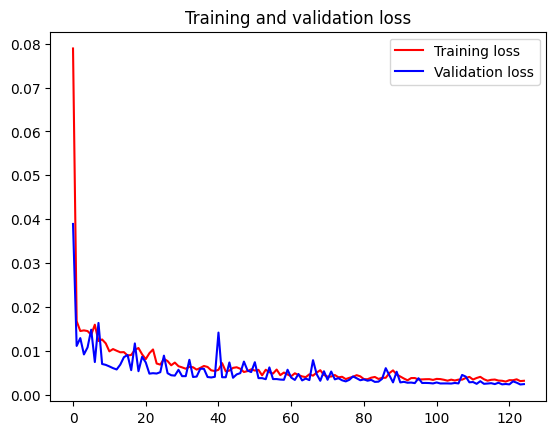

<Figure size 640x480 with 0 Axes>

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

** The model well predicted

* Predict the model

In [23]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


((203, 1), (130, 1))

In [24]:
maindf.shape

(365, 6)

# Evaluate the model

In [25]:
# Reshape the predictions and actual values back to their original shape
train_predict = np.concatenate((train_predict, np.zeros((train_predict.shape[0], maindf.shape[1]-1))), axis=1)
test_predict = np.concatenate((test_predict, np.zeros((test_predict.shape[0], maindf.shape[1]-1))), axis=1)

original_ytrain = np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], maindf.shape[1]-1))), axis=1)
original_ytest = np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], maindf.shape[1]-1))), axis=1)

# Inverse transform the data (the scaler was fitted on all columns, so we need to reverse all columns)
train_predict = scaler.inverse_transform(train_predict)[:, 0]  # Take only the 'Close' column after inverse transform
test_predict = scaler.inverse_transform(test_predict)[:, 0]    # Take only the 'Close' column after inverse transform
original_ytrain = scaler.inverse_transform(original_ytrain)[:, 0]  # Same for actual training values
original_ytest = scaler.inverse_transform(original_ytest)[:, 0]    # Same for actual testing values

# Now, `train_predict`, `test_predict`, `original_ytrain`, and `original_ytest` are in the original scale for 'Close

* RMSE MSE MAE

In [26]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  1936.0845114142837
Train data MSE:  3748423.2353382856
Train data MAE:  1526.605153518685
-------------------------------------------------------------------------------------
Test data RMSE:  1853.9800803925536
Test data MSE:  3437242.1384923793
Test data MAE:  1441.7491474683598


** RMSE (1853.98) is slightly lower than the training RMSE (1936.08), which might indicate a reasonable generalization of the model on unseen data.
** MSE (3437242.14) being slightly lower than the train MSE (3748423.24) can be seen as a positive sign.
** The slightly lower MAE in the test set again suggests a consistent performance across both sets.

* Explained variance regression score

In [27]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9573900233775553
Test data explained variance regression score: 0.959395867565807


** A higher score means a better model performance.

** Train data VRS has very high score, suggesting that the model generalizes well to unseen data.

** Test data VRS has very high score, suggesting that the model fits the training data well.

* RSQUARE Score

In [28]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.956904952682521
Test data R2 score: 0.9578551405860122


** A higher RSQUARE score indicates a better fit of the model to the data.

# Plotting last 15 days of dataset and next predicted 30 days

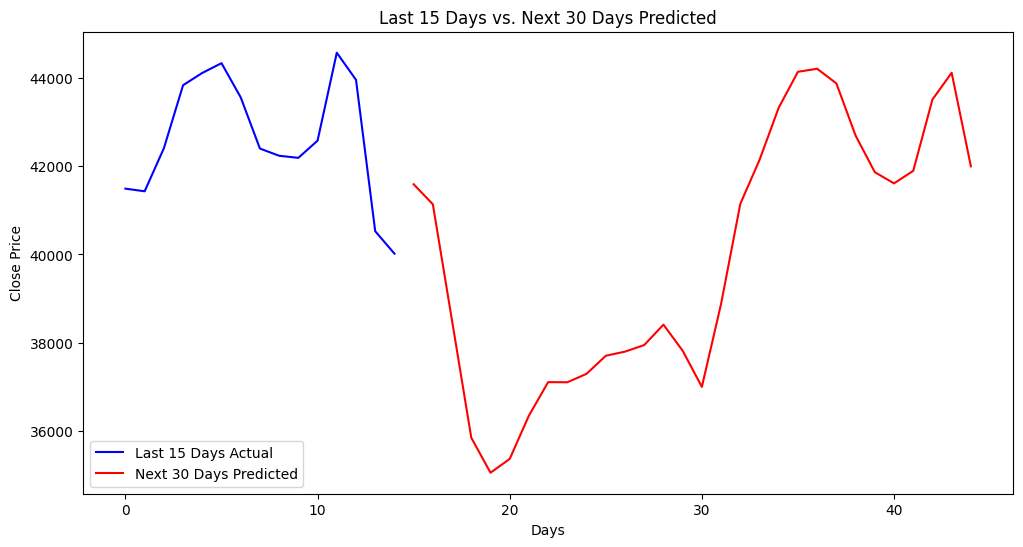

In [31]:
# prompt: Plotting last 15 days of dataset and next predicted 30 days

# Assuming 'y_test_original' contains the original test data and 'test_predict' contains the predicted values
# We also need the 'time_step' variable to determine the last 15 days.

look_back = time_step  # Assuming time_step is defined earlier in your code


# Extract the last 15 days of actual data
last_15_days_actual = original_ytest[-look_back:]

# Extract the predicted next 30 days
next_30_days_predicted = test_predict[-30:]

# Create the x-axis values for plotting
x_actual = list(range(len(last_15_days_actual)))
x_predicted = list(range(len(last_15_days_actual), len(last_15_days_actual) + len(next_30_days_predicted)))


# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(x_actual, last_15_days_actual, label='Last 15 Days Actual', color='blue')
plt.plot(x_predicted, next_30_days_predicted, label='Next 30 Days Predicted', color='red')
plt.title('Last 15 Days vs. Next 30 Days Predicted')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()